## Imports

In [99]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

import joblib

import pandas as pd
import numpy as np
import os

# sns.set(font_scale=1.25)

data_path = "../dataset/data/"
cell_types = os.listdir(data_path)

np.random.seed(42)


## Load the data

In [9]:
def load():

    full_train_data = np.array([])
    full_valid_data = np.array([])
    full_test_data = np.array([])
    full_train_labels = np.array([])
    full_valid_labels = np.array([])
    full_test_labels = np.array([])

    dirs = os.listdir(data_path)
    for folder in dirs:
        (train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load_clean_data(folder)
        print(f"{folder} loaded")
        
        # train
        full_train_data = np.append(full_train_data, train_data)
        full_train_labels = np.append(full_train_labels, train_labels)
        # valid
        full_valid_data = np.append(full_valid_data, valid_data)
        full_valid_labels = np.append(full_valid_labels, valid_labels)
        # test
        full_test_data = np.append(full_test_data, test_data)
        full_test_labels = np.append(full_test_labels, test_labels)

    # ? reshaping
    full_train_data = full_train_data.reshape(len(full_train_labels), 5, 100, 1)
    full_valid_data = full_valid_data.reshape(len(full_valid_labels), 5, 100, 1)
    full_test_data = full_test_data.reshape(len(full_test_labels), 5, 100, 1)

    return (
        (full_train_data, full_train_labels),
        (full_valid_data, full_valid_labels),
        (full_test_data, full_test_labels)
    )

In [10]:
def load_clean_data(folder_name):
    # data
    train_data = np.load(f"{data_path}{folder_name}/train_data.npy")
    valid_data = np.load(f"{data_path}{folder_name}/valid_data.npy")
    test_data = np.load(f"{data_path}{folder_name}/test_data.npy")
    # labels
    train_labels = np.load(f"{data_path}{folder_name}/train_labels.npy")
    valid_labels = np.load(f"{data_path}{folder_name}/valid_labels.npy")
    test_labels = np.load(f"{data_path}{folder_name}/test_labels.npy")
    # return complete tuples
    return ((train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels))

## Create the model

### Load the data

In [11]:
(train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load()

E003 loaded
E004 loaded
E005 loaded
E006 loaded
E007 loaded
E011 loaded
E012 loaded
E013 loaded
E016 loaded
E024 loaded
E027 loaded
E028 loaded
E037 loaded
E038 loaded
E047 loaded
E050 loaded
E053 loaded
E054 loaded
E055 loaded
E056 loaded
E057 loaded
E058 loaded
E059 loaded
E061 loaded
E062 loaded
E065 loaded
E066 loaded
E070 loaded
E071 loaded
E079 loaded
E082 loaded
E084 loaded
E085 loaded
E087 loaded
E094 loaded
E095 loaded
E096 loaded
E097 loaded
E098 loaded
E100 loaded
E104 loaded
E105 loaded
E106 loaded
E109 loaded
E112 loaded
E113 loaded
E114 loaded
E116 loaded
E117 loaded
E118 loaded
E119 loaded
E120 loaded
E122 loaded
E123 loaded
E127 loaded
E128 loaded


In [18]:
# visualize some stats about the data
print(f"{len(train_data)} training genes")
print(f"{len(valid_data)} validation genes")
print(f"{len(test_data)} test genes")
print(f"mean: {np.mean(train_data)}\nstd: {np.std(train_data)}")

369544 training genes
369544 validation genes
369432 test genes
mean: -8.957302339603253e-17
std: 0.999999999999999


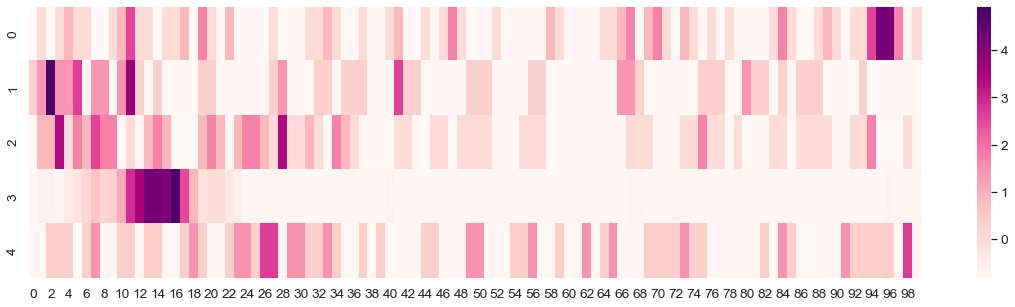

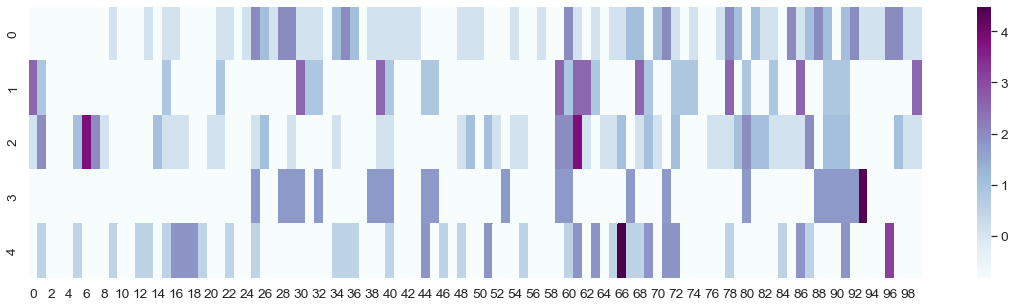

In [100]:
def plot_gene(gene,label):
    gene = gene.reshape(5,100)
    df = pd.DataFrame(gene)
    plt.figure(figsize=(20, 5))
    sns.heatmap(df, cmap=("RdPu" if label==1 else "BuPu"))

# test the function
plot_gene(train_data[0],train_labels[0])
plot_gene(train_data[1],train_labels[1])

## Utility functions

In [37]:
def plot_metrics(history):
    # AUC
    plt.plot(history.history["auc"], label="auc")
    plt.plot(history.history["val_auc"], label="val_auc")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.ylim([0.5, 1])
    plt.legend(loc="lower right")
    plt.show()
    # loss
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim([0,1])
    plt.legend(loc="lower right")
    plt.show()

## Modeling
Here we build several incremental models.

### Random Forest Classifier
`test : 0.8093656609906315`

In [20]:
train_data = train_data.reshape(len(train_data),5*100)
valid_data = valid_data.reshape(len(valid_data),5*100)
test_data = test_data.reshape(len(test_data),5*100)

In [21]:
clf = RandomForestClassifier(max_depth=20,n_estimators=100, random_state=0)
clf.fit(train_data, train_labels)

RandomForestClassifier(max_depth=20, random_state=0)

In [22]:
clf.score(test_data,test_labels)
roc_auc_score(test_labels, clf.predict_proba(test_data)[:,1])

0.8093656609906315

In [28]:
aucs = []
unit = 6597
for i in range(56):            
    test_auc = roc_auc_score(test_labels[i*unit:(i+1)*unit], clf.predict_proba(test_data[i*unit:(i+1)*unit])[:,1])
    aucs.append(test_auc)    
print(f"Random Forest Classifier | min: {min(aucs)} - max: {max(aucs)} - mean: {np.mean(aucs)}")
df_results = pd.DataFrame(list(zip(cell_types, aucs)),
               columns =['Cell-Type','AUC'])
# save results
df_results.to_csv("../results/rfc.csv",index=None)
# save model
joblib.dump(clf,"../models/rfc.joblib")

Random Forest Classifier | min: 0.7058680494603038 - max: 0.8852080926109228 - mean: 0.7924585638965371


['../models/rfc.joblib']

### FNN (Base model)

`loss: 0.4767 - auc: 0.7747 - accuracy: 0.7674`

`Baseline | min: 0.6968313455581665 - max: 0.8662115335464478 - mean: 0.7726049348711967`

In [66]:
train_data = train_data.reshape(len(train_data),5,100,1)
valid_data = valid_data.reshape(len(valid_data),5,100,1)
test_data = test_data.reshape(len(test_data),5,100,1)

In [67]:
model = models.Sequential(name="FNN")
model.add(layers.Flatten(input_shape=(5, 100, 1)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))

### Model - DeepChrome


In [44]:
train_data = train_data.reshape(len(train_data),5,100)
valid_data = valid_data.reshape(len(valid_data),5,100)
test_data = test_data.reshape(len(test_data),5,100)

In [45]:
model = models.Sequential(name="Deep_Chrome")
# stage 1
model.add(layers.Conv1D(10, 5, activation="relu", input_shape=(5,100), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling1D(pool_size=5))
# stage 2
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(625, activation='linear'))
model.add(layers.ReLU())
model.add(layers.Dense(125, activation='linear'))
# stage 3
model.add(layers.Dense(125, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Model - Ultra Chrome

`Ultra_Chrome | min: 0.7158114910125732 - max: 0.9036570191383362 - mean: 0.8033731132745743`

In [68]:
train_data = train_data.reshape(len(train_data),5,100,1)
valid_data = valid_data.reshape(len(valid_data),5,100,1)
test_data = test_data.reshape(len(test_data),5,100,1)

In [69]:
model = models.Sequential(name="Ultra_Chrome")
# stage 1 => CONV 2D
model.add(layers.Conv2D(50, 5, activation="relu", input_shape=(5,100,1), padding="same"))
model.add(layers.MaxPooling2D(pool_size=5))
# stage 2 => FNN
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
# final stage
model.add(layers.Dense(1, activation='sigmoid'))

### Chrome Focus

`---`

`---`

### Visualize the model

In [70]:
model.summary()

Model: "Ultra_Chrome"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 5, 100, 50)        1300      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 20, 50)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                64064     
_________________________________________________________________
batch_normalization_7 (Batch (None, 64)                256       
_________________________________________________________________
dense_24 (Dense)             (None, 256)              

## Training

### Unique Training

In [71]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["AUC"])

history = model.fit(train_data, train_labels, epochs=10, validation_data=(valid_data, valid_labels))
# history = model.fit(valid_data, valid_labels, epochs=10, validation_data=(train_data, train_labels))

# saving the model
model.save(f"../models/{model.name}")

Epoch 1/10
11549/11549 [==============================] - 223s 19ms/step - loss: 0.6103 - auc: 0.6983 - val_loss: 0.5295 - val_auc: 0.7766
Epoch 2/10
11549/11549 [==============================] - 224s 19ms/step - loss: 0.5764 - auc: 0.7414 - val_loss: 0.5395 - val_auc: 0.7782 loss: 0.5764 - auc: 0.741
Epoch 3/10
11549/11549 [==============================] - 249s 22ms/step - loss: 0.5704 - auc: 0.7493 - val_loss: 0.5230 - val_auc: 0.7806
Epoch 4/10
11549/11549 [==============================] - 271s 23ms/step - loss: 0.5700 - auc: 0.7502 - val_loss: 0.5197 - val_auc: 0.7852- loss: 0.5700 - auc:  - ETA: 2s -  - ETA: 1s - loss: 0.
Epoch 5/10
11549/11549 [==============================] - 270s 23ms/step - loss: 0.5663 - auc: 0.7541 - val_loss: 0.5211 - val_auc: 0.7839
Epoch 6/10
11549/11549 [==============================] - 277s 24ms/step - loss: 0.5645 - auc: 0.7571 - val_loss: 0.5224 - val_auc: 0.7854
Epoch 7/10
11549/11549 [==============================] - 294s 25ms/step - loss: 0.5

INFO:tensorflow:Assets written to: ../models/Ultra_Chrome\assets


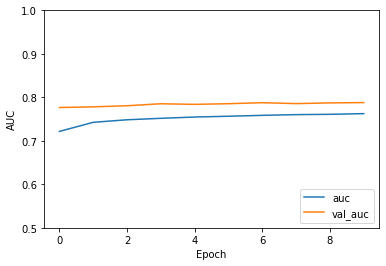

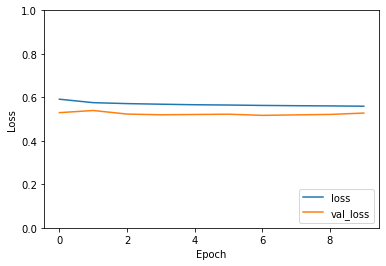

In [72]:
plot_metrics(history)

### Separate Training

In [107]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["AUC"])

separated_models = []
for i in range(56):
    new_model = model
    history = new_model.fit(train_data[i*unit:(i+1)*unit], train_labels[i*unit:(i+1)*unit],
                            validation_data=(valid_data[i*unit:(i+1)*unit], valid_labels[i*unit:(i+1)*unit]),
                            epochs=20)  # todo: modify number of epochs
    # saving the model
    separated_models.append(new_model)
    new_model.save(f"../models/separated/{new_model.name}/Cell-{i+1}")
    

Epoch 1/20
207/207 [==============================] - 4s 12ms/step - loss: 0.5487 - auc: 0.7489 - val_loss: 0.5721 - val_auc: 0.7034
Epoch 2/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5318 - auc: 0.7763 - val_loss: 0.5692 - val_auc: 0.7005
Epoch 3/20
207/207 [==============================] - 3s 16ms/step - loss: 0.5248 - auc: 0.7763 - val_loss: 0.5831 - val_auc: 0.6870
Epoch 4/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5338 - auc: 0.7712 - val_loss: 0.5913 - val_auc: 0.6983
Epoch 5/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5197 - auc: 0.7919 - val_loss: 0.5847 - val_auc: 0.6983
Epoch 6/20
207/207 [==============================] - 3s 15ms/step - loss: 0.4917 - auc: 0.8118 - val_loss: 0.6081 - val_auc: 0.6936
Epoch 7/20
207/207 [==============================] - 3s 14ms/step - loss: 0.4968 - auc: 0.8123 - val_loss: 0.5988 - val_auc: 0.6905
Epoch 8/20
207/207 [==============================] - 3s 14ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-1\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5993 - auc: 0.7479 - val_loss: 0.5829 - val_auc: 0.7480
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5439 - auc: 0.7861 - val_loss: 0.5776 - val_auc: 0.7517
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5371 - auc: 0.7938 - val_loss: 0.5747 - val_auc: 0.7520
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5277 - auc: 0.7987 - val_loss: 0.5828 - val_auc: 0.7538
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5187 - auc: 0.8083 - val_loss: 0.5919 - val_auc: 0.7524
Epoch 6/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5076 - auc: 0.8194 - val_loss: 0.6012 - val_auc: 0.7424
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.4995 - auc: 0.8236 - val_loss: 0.6009 - val_auc: 0.7451
Epoch 8/20
207/207 [==============================] - 3s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-2\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.6046 - auc: 0.7375 - val_loss: 0.5582 - val_auc: 0.7567
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5577 - auc: 0.7678 - val_loss: 0.5507 - val_auc: 0.7636
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5494 - auc: 0.7787 - val_loss: 0.5525 - val_auc: 0.7620
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5340 - auc: 0.7941 - val_loss: 0.5590 - val_auc: 0.7591
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5331 - auc: 0.7970 - val_loss: 0.5683 - val_auc: 0.7530
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5295 - auc: 0.7991 - val_loss: 0.5607 - val_auc: 0.7604
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5190 - auc: 0.8087 - val_loss: 0.5630 - val_auc: 0.7575
Epoch 8/20
207/207 [==============================] - 2s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-3\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.6123 - auc: 0.7321 - val_loss: 0.5599 - val_auc: 0.7556
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5693 - auc: 0.7592 - val_loss: 0.5572 - val_auc: 0.7593
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5614 - auc: 0.7655 - val_loss: 0.5594 - val_auc: 0.7595
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5603 - auc: 0.7699 - val_loss: 0.5586 - val_auc: 0.7569
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5513 - auc: 0.7793 - val_loss: 0.5562 - val_auc: 0.7592
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5442 - auc: 0.7850 - val_loss: 0.5630 - val_auc: 0.7567
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5393 - auc: 0.7896 - val_loss: 0.5637 - val_auc: 0.7551
Epoch 8/20
207/207 [==============================] - 3s 14ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-4\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.6004 - auc: 0.6861 - val_loss: 0.5310 - val_auc: 0.7225
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5642 - auc: 0.7085 - val_loss: 0.5265 - val_auc: 0.7273
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5569 - auc: 0.7203 - val_loss: 0.5250 - val_auc: 0.7283
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5512 - auc: 0.7255 - val_loss: 0.5266 - val_auc: 0.7265
Epoch 5/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5480 - auc: 0.7297 - val_loss: 0.5263 - val_auc: 0.7273
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5468 - auc: 0.7326 - val_loss: 0.5293 - val_auc: 0.7248
Epoch 7/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5365 - auc: 0.7463 - val_loss: 0.5357 - val_auc: 0.7199
Epoch 8/20
207/207 [==============================] - 3s 14ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-5\assets


Epoch 1/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5687 - auc: 0.6455 - val_loss: 0.5258 - val_auc: 0.6695
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5360 - auc: 0.6752 - val_loss: 0.5213 - val_auc: 0.6748
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5323 - auc: 0.6807 - val_loss: 0.5203 - val_auc: 0.6739
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5273 - auc: 0.6920 - val_loss: 0.5201 - val_auc: 0.6764
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5193 - auc: 0.7067 - val_loss: 0.5228 - val_auc: 0.6747
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5179 - auc: 0.7105 - val_loss: 0.5221 - val_auc: 0.6702
Epoch 7/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5122 - auc: 0.7216 - val_loss: 0.5249 - val_auc: 0.6745
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-6\assets


Epoch 1/20
207/207 [==============================] - 3s 12ms/step - loss: 0.6000 - auc: 0.6654 - val_loss: 0.5326 - val_auc: 0.7052
Epoch 2/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5633 - auc: 0.6929 - val_loss: 0.5245 - val_auc: 0.7127
Epoch 3/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5534 - auc: 0.7099 - val_loss: 0.5236 - val_auc: 0.7100
Epoch 4/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5521 - auc: 0.7094 - val_loss: 0.5270 - val_auc: 0.7114
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5447 - auc: 0.7245 - val_loss: 0.5243 - val_auc: 0.7135
Epoch 6/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5420 - auc: 0.7265 - val_loss: 0.5255 - val_auc: 0.7113
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5284 - auc: 0.7494 - val_loss: 0.5282 - val_auc: 0.7139
Epoch 8/20
207/207 [==============================] - 2s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-7\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.6082 - auc: 0.6557 - val_loss: 0.5346 - val_auc: 0.7091
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5790 - auc: 0.6825 - val_loss: 0.5258 - val_auc: 0.7193
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5695 - auc: 0.6988 - val_loss: 0.5273 - val_auc: 0.7182
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5667 - auc: 0.6993 - val_loss: 0.5250 - val_auc: 0.7190
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5621 - auc: 0.7060 - val_loss: 0.5250 - val_auc: 0.7217
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5570 - auc: 0.7146 - val_loss: 0.5246 - val_auc: 0.7224
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5520 - auc: 0.7283 - val_loss: 0.5269 - val_auc: 0.7185
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-9\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.6211 - auc: 0.6622 - val_loss: 0.5575 - val_auc: 0.6963
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5837 - auc: 0.6905 - val_loss: 0.5467 - val_auc: 0.7057
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5748 - auc: 0.6990 - val_loss: 0.5448 - val_auc: 0.7066
Epoch 4/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5736 - auc: 0.7035 - val_loss: 0.5406 - val_auc: 0.7101
Epoch 5/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5686 - auc: 0.7137 - val_loss: 0.5443 - val_auc: 0.7069
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5617 - auc: 0.7186 - val_loss: 0.5430 - val_auc: 0.7099
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5571 - auc: 0.7256 - val_loss: 0.5511 - val_auc: 0.7084
Epoch 8/20
207/207 [==============================] - 3s 15ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-10\assets


Epoch 1/20
207/207 [==============================] - 3s 15ms/step - loss: 0.6225 - auc: 0.7087 - val_loss: 0.5704 - val_auc: 0.7456
Epoch 2/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5873 - auc: 0.7326 - val_loss: 0.5615 - val_auc: 0.7561
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5783 - auc: 0.7464 - val_loss: 0.5561 - val_auc: 0.7604
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5711 - auc: 0.7513 - val_loss: 0.5560 - val_auc: 0.7605
Epoch 5/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5681 - auc: 0.7585 - val_loss: 0.5531 - val_auc: 0.7617
Epoch 6/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5649 - auc: 0.7606 - val_loss: 0.5500 - val_auc: 0.7659
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5546 - auc: 0.7708 - val_loss: 0.5564 - val_auc: 0.7653
Epoch 8/20
207/207 [==============================] - 3s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-11\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.6008 - auc: 0.7236 - val_loss: 0.5493 - val_auc: 0.7574
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5708 - auc: 0.7442 - val_loss: 0.5377 - val_auc: 0.7673
Epoch 3/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5629 - auc: 0.7513 - val_loss: 0.5373 - val_auc: 0.7673
Epoch 4/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5591 - auc: 0.7562 - val_loss: 0.5358 - val_auc: 0.7693
Epoch 5/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5528 - auc: 0.7674 - val_loss: 0.5374 - val_auc: 0.7682
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5442 - auc: 0.7702 - val_loss: 0.5413 - val_auc: 0.7661
Epoch 7/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5403 - auc: 0.7756 - val_loss: 0.5394 - val_auc: 0.7700
Epoch 8/20
207/207 [==============================] - 3s 14ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-13\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5657 - auc: 0.7575 - val_loss: 0.5423 - val_auc: 0.7910
Epoch 2/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5445 - auc: 0.7736 - val_loss: 0.5329 - val_auc: 0.7932
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5425 - auc: 0.7825 - val_loss: 0.5272 - val_auc: 0.7947
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5347 - auc: 0.7871 - val_loss: 0.5251 - val_auc: 0.7952
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5288 - auc: 0.7958 - val_loss: 0.5281 - val_auc: 0.7947
Epoch 6/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5259 - auc: 0.7963 - val_loss: 0.5352 - val_auc: 0.7934
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5202 - auc: 0.8009 - val_loss: 0.5253 - val_auc: 0.7949
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-14\assets


Epoch 1/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5813 - auc: 0.7437 - val_loss: 0.5235 - val_auc: 0.7978
Epoch 2/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5536 - auc: 0.7647 - val_loss: 0.5132 - val_auc: 0.8030
Epoch 3/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5446 - auc: 0.7717 - val_loss: 0.5114 - val_auc: 0.8039
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5349 - auc: 0.7829 - val_loss: 0.5144 - val_auc: 0.8024
Epoch 5/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5339 - auc: 0.7879 - val_loss: 0.5207 - val_auc: 0.7982
Epoch 6/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5328 - auc: 0.7890 - val_loss: 0.5198 - val_auc: 0.8005
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5245 - auc: 0.7932 - val_loss: 0.5164 - val_auc: 0.8003
Epoch 8/20
207/207 [==============================] - 3s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-15\assets


Epoch 1/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5797 - auc: 0.6915 - val_loss: 0.5239 - val_auc: 0.7293
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5389 - auc: 0.7154 - val_loss: 0.5248 - val_auc: 0.7283
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5331 - auc: 0.7205 - val_loss: 0.5194 - val_auc: 0.7297
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5239 - auc: 0.7342 - val_loss: 0.5222 - val_auc: 0.7301
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5256 - auc: 0.7317 - val_loss: 0.5223 - val_auc: 0.7307
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5221 - auc: 0.7362 - val_loss: 0.5314 - val_auc: 0.7278
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5161 - auc: 0.7444 - val_loss: 0.5291 - val_auc: 0.7283
Epoch 8/20
207/207 [==============================] - 3s 14ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-16\assets


Epoch 1/20
207/207 [==============================] - 4s 17ms/step - loss: 0.5901 - auc: 0.6922 - val_loss: 0.5325 - val_auc: 0.7370
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5658 - auc: 0.7071 - val_loss: 0.5297 - val_auc: 0.7403
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5521 - auc: 0.7203 - val_loss: 0.5268 - val_auc: 0.7430
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5495 - auc: 0.7212 - val_loss: 0.5282 - val_auc: 0.7424
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5472 - auc: 0.7340 - val_loss: 0.5314 - val_auc: 0.7398
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5455 - auc: 0.7319 - val_loss: 0.5284 - val_auc: 0.7446
Epoch 7/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5390 - auc: 0.7437 - val_loss: 0.5278 - val_auc: 0.7417
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-17\assets


207/207 [==============================] - 4s 17ms/step - loss: 0.5894 - auc: 0.6887 - val_loss: 0.5329 - val_auc: 0.7376
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5654 - auc: 0.7111 - val_loss: 0.5230 - val_auc: 0.7393
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5569 - auc: 0.7197 - val_loss: 0.5231 - val_auc: 0.7414
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5517 - auc: 0.7242 - val_loss: 0.5230 - val_auc: 0.7401
Epoch 5/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5488 - auc: 0.7259 - val_loss: 0.5215 - val_auc: 0.7404
Epoch 6/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5459 - auc: 0.7274 - val_loss: 0.5224 - val_auc: 0.7399
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5401 - auc: 0.7396 - val_loss: 0.5222 - val_auc: 0.7406
Epoch 8/20
207/207 [==============================] - 3s 12ms/step - loss: 0.537

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-18\assets


Epoch 1/20
207/207 [==============================] - 3s 12ms/step - loss: 0.6065 - auc: 0.7154 - val_loss: 0.5408 - val_auc: 0.7725
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5721 - auc: 0.7373 - val_loss: 0.5332 - val_auc: 0.7775
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5652 - auc: 0.7466 - val_loss: 0.5279 - val_auc: 0.7801
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5584 - auc: 0.7551 - val_loss: 0.5227 - val_auc: 0.7872
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5538 - auc: 0.7618 - val_loss: 0.5236 - val_auc: 0.7877
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5488 - auc: 0.7629 - val_loss: 0.5245 - val_auc: 0.7859
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5434 - auc: 0.7686 - val_loss: 0.5248 - val_auc: 0.7850
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-20\assets


Epoch 1/20
207/207 [==============================] - 3s 15ms/step - loss: 0.4146 - auc: 0.8782 - val_loss: 0.4212 - val_auc: 0.8894
Epoch 2/20
207/207 [==============================] - 3s 15ms/step - loss: 0.3811 - auc: 0.8980 - val_loss: 0.4313 - val_auc: 0.8938
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.3695 - auc: 0.9038 - val_loss: 0.4070 - val_auc: 0.8971
Epoch 4/20
207/207 [==============================] - 3s 14ms/step - loss: 0.3598 - auc: 0.9095 - val_loss: 0.4027 - val_auc: 0.8988
Epoch 5/20
207/207 [==============================] - 3s 15ms/step - loss: 0.3554 - auc: 0.9115 - val_loss: 0.4053 - val_auc: 0.8991
Epoch 6/20
207/207 [==============================] - 3s 15ms/step - loss: 0.3487 - auc: 0.9157 - val_loss: 0.4139 - val_auc: 0.8986
Epoch 7/20
207/207 [==============================] - 3s 14ms/step - loss: 0.3407 - auc: 0.9200 - val_loss: 0.4112 - val_auc: 0.8988
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-21\assets


Epoch 1/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5843 - auc: 0.7593 - val_loss: 0.5532 - val_auc: 0.7791
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5467 - auc: 0.7634 - val_loss: 0.5215 - val_auc: 0.7888
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5338 - auc: 0.7815 - val_loss: 0.5184 - val_auc: 0.7900
Epoch 4/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5308 - auc: 0.7783 - val_loss: 0.5207 - val_auc: 0.7898
Epoch 5/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5274 - auc: 0.7854 - val_loss: 0.5190 - val_auc: 0.7886
Epoch 6/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5222 - auc: 0.7876 - val_loss: 0.5267 - val_auc: 0.7860
Epoch 7/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5210 - auc: 0.7892 - val_loss: 0.5259 - val_auc: 0.7870
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-22\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.4635 - auc: 0.8478 - val_loss: 0.4349 - val_auc: 0.8848
Epoch 2/20
207/207 [==============================] - 3s 12ms/step - loss: 0.4163 - auc: 0.8768 - val_loss: 0.4286 - val_auc: 0.8887
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3993 - auc: 0.8857 - val_loss: 0.4225 - val_auc: 0.8898
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3919 - auc: 0.8919 - val_loss: 0.4231 - val_auc: 0.8905
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.3897 - auc: 0.8933 - val_loss: 0.4218 - val_auc: 0.8908
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3819 - auc: 0.8969 - val_loss: 0.4314 - val_auc: 0.8906
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3762 - auc: 0.8999 - val_loss: 0.4339 - val_auc: 0.8900
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-23\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5730 - auc: 0.7583 - val_loss: 0.5210 - val_auc: 0.7900
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5419 - auc: 0.7629 - val_loss: 0.5145 - val_auc: 0.7922
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5349 - auc: 0.7697 - val_loss: 0.5152 - val_auc: 0.7936
Epoch 4/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5285 - auc: 0.7799 - val_loss: 0.5178 - val_auc: 0.7934
Epoch 5/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5231 - auc: 0.7792 - val_loss: 0.5184 - val_auc: 0.7911
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5257 - auc: 0.7768 - val_loss: 0.5176 - val_auc: 0.7935
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5218 - auc: 0.7864 - val_loss: 0.5234 - val_auc: 0.7923
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-24\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5958 - auc: 0.7278 - val_loss: 0.5527 - val_auc: 0.7820
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5682 - auc: 0.7500 - val_loss: 0.5466 - val_auc: 0.7847
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5597 - auc: 0.7540 - val_loss: 0.5472 - val_auc: 0.7823
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5529 - auc: 0.7624 - val_loss: 0.5397 - val_auc: 0.7844
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5508 - auc: 0.7671 - val_loss: 0.5383 - val_auc: 0.7843
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5480 - auc: 0.7697 - val_loss: 0.5441 - val_auc: 0.7820
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5447 - auc: 0.7748 - val_loss: 0.5434 - val_auc: 0.7826
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-26\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.6145 - auc: 0.7101 - val_loss: 0.5844 - val_auc: 0.7407
Epoch 2/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5928 - auc: 0.7265 - val_loss: 0.5781 - val_auc: 0.7470
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5854 - auc: 0.7359 - val_loss: 0.5792 - val_auc: 0.7490
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5841 - auc: 0.7399 - val_loss: 0.5751 - val_auc: 0.7496
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5758 - auc: 0.7453 - val_loss: 0.5745 - val_auc: 0.7509
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5724 - auc: 0.7511 - val_loss: 0.5761 - val_auc: 0.7505
Epoch 7/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5688 - auc: 0.7560 - val_loss: 0.5758 - val_auc: 0.7516
Epoch 8/20
207/207 [==============================] - 3s 14ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-28\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5932 - auc: 0.6175 - val_loss: 0.5534 - val_auc: 0.6589
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5615 - auc: 0.6444 - val_loss: 0.5474 - val_auc: 0.6582
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5587 - auc: 0.6481 - val_loss: 0.5467 - val_auc: 0.6552
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5550 - auc: 0.6546 - val_loss: 0.5458 - val_auc: 0.6597
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5501 - auc: 0.6628 - val_loss: 0.5476 - val_auc: 0.6602
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5453 - auc: 0.6724 - val_loss: 0.5463 - val_auc: 0.6592
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5428 - auc: 0.6832 - val_loss: 0.5510 - val_auc: 0.6570
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-29\assets


Epoch 1/20
207/207 [==============================] - 3s 12ms/step - loss: 0.6112 - auc: 0.6006 - val_loss: 0.5487 - val_auc: 0.6525
Epoch 2/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5772 - auc: 0.6379 - val_loss: 0.5388 - val_auc: 0.6662
Epoch 3/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5743 - auc: 0.6457 - val_loss: 0.5339 - val_auc: 0.6701
Epoch 4/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5683 - auc: 0.6513 - val_loss: 0.5355 - val_auc: 0.6679
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5631 - auc: 0.6621 - val_loss: 0.5343 - val_auc: 0.6682
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5636 - auc: 0.6627 - val_loss: 0.5340 - val_auc: 0.6713
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5603 - auc: 0.6696 - val_loss: 0.5342 - val_auc: 0.6742
Epoch 8/20
207/207 [==============================] - 2s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-30\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5952 - auc: 0.6803 - val_loss: 0.5549 - val_auc: 0.7243
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5812 - auc: 0.6961 - val_loss: 0.5625 - val_auc: 0.7318
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5744 - auc: 0.7081 - val_loss: 0.5540 - val_auc: 0.7326
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5673 - auc: 0.7137 - val_loss: 0.5493 - val_auc: 0.7347
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5649 - auc: 0.7170 - val_loss: 0.5754 - val_auc: 0.7274
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5686 - auc: 0.7061 - val_loss: 0.5496 - val_auc: 0.7314
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5616 - auc: 0.7189 - val_loss: 0.5473 - val_auc: 0.7318
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-31\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5426 - auc: 0.6050 - val_loss: 0.4728 - val_auc: 0.6596s - loss: 0.
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5057 - auc: 0.6275 - val_loss: 0.4684 - val_auc: 0.6603
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5011 - auc: 0.6340 - val_loss: 0.4660 - val_auc: 0.6647
Epoch 4/20
207/207 [==============================] - 3s 14ms/step - loss: 0.4943 - auc: 0.6521 - val_loss: 0.4657 - val_auc: 0.6618
Epoch 5/20
207/207 [==============================] - 3s 16ms/step - loss: 0.4920 - auc: 0.6566 - val_loss: 0.4662 - val_auc: 0.6607
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.4878 - auc: 0.6701 - val_loss: 0.4681 - val_auc: 0.6605
Epoch 7/20
207/207 [==============================] - 3s 15ms/step - loss: 0.4880 - auc: 0.6729 - val_loss: 0.4672 - val_auc: 0.6637
Epoch 8/20
207/207 [==============================] - 3s 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-32\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5538 - auc: 0.6396 - val_loss: 0.5028 - val_auc: 0.6653
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5350 - auc: 0.6543 - val_loss: 0.4892 - val_auc: 0.6762
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5212 - auc: 0.6793 - val_loss: 0.4896 - val_auc: 0.6818
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5181 - auc: 0.6861 - val_loss: 0.4902 - val_auc: 0.6805
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5164 - auc: 0.6870 - val_loss: 0.4877 - val_auc: 0.6846
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5135 - auc: 0.6952 - val_loss: 0.4892 - val_auc: 0.6862
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5078 - auc: 0.7033 - val_loss: 0.4894 - val_auc: 0.6836
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-33\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.6039 - auc: 0.5978 - val_loss: 0.5446 - val_auc: 0.6598
Epoch 2/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5695 - auc: 0.6279 - val_loss: 0.5356 - val_auc: 0.6639
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5628 - auc: 0.6361 - val_loss: 0.5324 - val_auc: 0.6715
Epoch 4/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5536 - auc: 0.6604 - val_loss: 0.5244 - val_auc: 0.6729
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5542 - auc: 0.6578 - val_loss: 0.5295 - val_auc: 0.6731
Epoch 6/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5525 - auc: 0.6583 - val_loss: 0.5243 - val_auc: 0.6775
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5449 - auc: 0.6749 - val_loss: 0.5252 - val_auc: 0.6742
Epoch 8/20
207/207 [==============================] - 3s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-34\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.6053 - auc: 0.6024 - val_loss: 0.5566 - val_auc: 0.6480
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5739 - auc: 0.6394 - val_loss: 0.5523 - val_auc: 0.6579
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5656 - auc: 0.6609 - val_loss: 0.5398 - val_auc: 0.6632
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5606 - auc: 0.6677 - val_loss: 0.5395 - val_auc: 0.6644
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5611 - auc: 0.6660 - val_loss: 0.5363 - val_auc: 0.6664
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5572 - auc: 0.6800 - val_loss: 0.5372 - val_auc: 0.6626
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5509 - auc: 0.6873 - val_loss: 0.5368 - val_auc: 0.6657
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-36\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.6096 - auc: 0.6159 - val_loss: 0.5362 - val_auc: 0.6638
Epoch 2/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5649 - auc: 0.6405 - val_loss: 0.5338 - val_auc: 0.6648
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5559 - auc: 0.6560 - val_loss: 0.5279 - val_auc: 0.6686
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5522 - auc: 0.6613 - val_loss: 0.5256 - val_auc: 0.6703
Epoch 5/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5465 - auc: 0.6704 - val_loss: 0.5259 - val_auc: 0.6711
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5430 - auc: 0.6815 - val_loss: 0.5242 - val_auc: 0.6740
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5404 - auc: 0.6842 - val_loss: 0.5252 - val_auc: 0.6714
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-37\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5733 - auc: 0.6398 - val_loss: 0.5160 - val_auc: 0.6914
Epoch 2/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5518 - auc: 0.6643 - val_loss: 0.5069 - val_auc: 0.6970
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5430 - auc: 0.6841 - val_loss: 0.5035 - val_auc: 0.7010
Epoch 4/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5369 - auc: 0.6941 - val_loss: 0.5020 - val_auc: 0.7026
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5335 - auc: 0.6959 - val_loss: 0.5055 - val_auc: 0.7011
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5256 - auc: 0.7145 - val_loss: 0.5045 - val_auc: 0.7057
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5298 - auc: 0.7059 - val_loss: 0.5042 - val_auc: 0.7032
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-38\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.6100 - auc: 0.6061 - val_loss: 0.5658 - val_auc: 0.6622
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5806 - auc: 0.6312 - val_loss: 0.5651 - val_auc: 0.6562
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5765 - auc: 0.6399 - val_loss: 0.5523 - val_auc: 0.6703
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5652 - auc: 0.6606 - val_loss: 0.5496 - val_auc: 0.6740
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5637 - auc: 0.6661 - val_loss: 0.5487 - val_auc: 0.6699
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5613 - auc: 0.6699 - val_loss: 0.5455 - val_auc: 0.6751
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5571 - auc: 0.6779 - val_loss: 0.5509 - val_auc: 0.6785
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-39\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.4750 - auc: 0.8480 - val_loss: 0.4476 - val_auc: 0.8824
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.4106 - auc: 0.8854 - val_loss: 0.4442 - val_auc: 0.8874
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3953 - auc: 0.8940 - val_loss: 0.4308 - val_auc: 0.8898
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3876 - auc: 0.8989 - val_loss: 0.4254 - val_auc: 0.8929
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3796 - auc: 0.9030 - val_loss: 0.4278 - val_auc: 0.8940
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3680 - auc: 0.9090 - val_loss: 0.4297 - val_auc: 0.8936
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3616 - auc: 0.9129 - val_loss: 0.4342 - val_auc: 0.8948
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-40\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.6588 - auc: 0.6610 - val_loss: 0.5679 - val_auc: 0.7126
Epoch 2/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5990 - auc: 0.6848 - val_loss: 0.5627 - val_auc: 0.7170
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5916 - auc: 0.6976 - val_loss: 0.5576 - val_auc: 0.7186
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5883 - auc: 0.6976 - val_loss: 0.5536 - val_auc: 0.7213
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5821 - auc: 0.7079 - val_loss: 0.5518 - val_auc: 0.7219
Epoch 6/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5779 - auc: 0.7155 - val_loss: 0.5516 - val_auc: 0.7223
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5745 - auc: 0.7183 - val_loss: 0.5533 - val_auc: 0.7214
Epoch 8/20
207/207 [==============================] - 3s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-41\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.6141 - auc: 0.6629 - val_loss: 0.5557 - val_auc: 0.7143
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5900 - auc: 0.6899 - val_loss: 0.5534 - val_auc: 0.7146
Epoch 3/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5897 - auc: 0.6911 - val_loss: 0.5497 - val_auc: 0.7165
Epoch 4/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5850 - auc: 0.6955 - val_loss: 0.5500 - val_auc: 0.7190
Epoch 5/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5787 - auc: 0.7083 - val_loss: 0.5486 - val_auc: 0.7192
Epoch 6/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5786 - auc: 0.7062 - val_loss: 0.5496 - val_auc: 0.7188
Epoch 7/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5739 - auc: 0.7171 - val_loss: 0.5480 - val_auc: 0.7208
Epoch 8/20
207/207 [==============================] - 3s 15ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-43\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5937 - auc: 0.6149 - val_loss: 0.5299 - val_auc: 0.6600
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5708 - auc: 0.6412 - val_loss: 0.5288 - val_auc: 0.6649
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5673 - auc: 0.6465 - val_loss: 0.5234 - val_auc: 0.6678
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5607 - auc: 0.6575 - val_loss: 0.5225 - val_auc: 0.6668
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5539 - auc: 0.6711 - val_loss: 0.5217 - val_auc: 0.6700loss: 0.5541 - auc: 0.671
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5533 - auc: 0.6739 - val_loss: 0.5220 - val_auc: 0.6672
Epoch 7/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5475 - auc: 0.6881 - val_loss: 0.5217 - val_auc: 0.6710
Epoch 8/20
207/207 [========================

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-44\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5367 - auc: 0.5801 - val_loss: 0.4674 - val_auc: 0.6209
Epoch 2/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5081 - auc: 0.6069 - val_loss: 0.4629 - val_auc: 0.6325
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.4989 - auc: 0.6306 - val_loss: 0.4582 - val_auc: 0.6347
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.4961 - auc: 0.6400 - val_loss: 0.4591 - val_auc: 0.6358
Epoch 5/20
207/207 [==============================] - 3s 14ms/step - loss: 0.4929 - auc: 0.6448 - val_loss: 0.4586 - val_auc: 0.6315
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.4896 - auc: 0.6565 - val_loss: 0.4614 - val_auc: 0.6278
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.4880 - auc: 0.6554 - val_loss: 0.4602 - val_auc: 0.6345
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-46\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.6105 - auc: 0.7070 - val_loss: 0.5482 - val_auc: 0.7612
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5750 - auc: 0.7378 - val_loss: 0.5343 - val_auc: 0.7711
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5658 - auc: 0.7520 - val_loss: 0.5274 - val_auc: 0.7770
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5589 - auc: 0.7594 - val_loss: 0.5241 - val_auc: 0.7797
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5528 - auc: 0.7622 - val_loss: 0.5251 - val_auc: 0.7799
Epoch 6/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5444 - auc: 0.7740 - val_loss: 0.5271 - val_auc: 0.7781
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5467 - auc: 0.7692 - val_loss: 0.5257 - val_auc: 0.7808
Epoch 8/20
207/207 [==============================] - 2s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-47\assets


Epoch 1/20
207/207 [==============================] - 3s 15ms/step - loss: 0.4075 - auc: 0.8902 - val_loss: 0.3996 - val_auc: 0.9064
Epoch 2/20
207/207 [==============================] - 3s 14ms/step - loss: 0.3663 - auc: 0.9065 - val_loss: 0.3815 - val_auc: 0.9098
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3522 - auc: 0.9130 - val_loss: 0.3881 - val_auc: 0.9118
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3434 - auc: 0.9189 - val_loss: 0.3864 - val_auc: 0.9140
Epoch 5/20
207/207 [==============================] - 3s 14ms/step - loss: 0.3369 - auc: 0.9220 - val_loss: 0.3861 - val_auc: 0.9131
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3328 - auc: 0.9235 - val_loss: 0.3904 - val_auc: 0.9120
Epoch 7/20
207/207 [==============================] - 2s 12ms/step - loss: 0.3266 - auc: 0.9284 - val_loss: 0.3822 - val_auc: 0.9145
Epoch 8/20
207/207 [==============================] - 3s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-48\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.3768 - auc: 0.9031 - val_loss: 0.3450 - val_auc: 0.9282
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3486 - auc: 0.9136 - val_loss: 0.3439 - val_auc: 0.9300
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3341 - auc: 0.9211 - val_loss: 0.3485 - val_auc: 0.9307
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3280 - auc: 0.9241 - val_loss: 0.3418 - val_auc: 0.9313
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3258 - auc: 0.9255 - val_loss: 0.3421 - val_auc: 0.9316
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3190 - auc: 0.9289 - val_loss: 0.3379 - val_auc: 0.9322
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.3171 - auc: 0.9296 - val_loss: 0.3401 - val_auc: 0.9312
Epoch 8/20
207/207 [==============================] - 3s 14ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-49\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5864 - auc: 0.7616 - val_loss: 0.5156 - val_auc: 0.7957
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5362 - auc: 0.7812 - val_loss: 0.5043 - val_auc: 0.7993
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5300 - auc: 0.7841 - val_loss: 0.5038 - val_auc: 0.7999
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5260 - auc: 0.7850 - val_loss: 0.5006 - val_auc: 0.7994
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5247 - auc: 0.7882 - val_loss: 0.4993 - val_auc: 0.8012
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5204 - auc: 0.7898 - val_loss: 0.5023 - val_auc: 0.7994
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5143 - auc: 0.7969 - val_loss: 0.5053 - val_auc: 0.8004
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-50\assets


Epoch 1/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5759 - auc: 0.7413 - val_loss: 0.5361 - val_auc: 0.7857
Epoch 2/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5489 - auc: 0.7613 - val_loss: 0.5242 - val_auc: 0.7887
Epoch 3/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5449 - auc: 0.7640 - val_loss: 0.5231 - val_auc: 0.7877
Epoch 4/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5412 - auc: 0.7676 - val_loss: 0.5174 - val_auc: 0.7893
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5360 - auc: 0.7750 - val_loss: 0.5190 - val_auc: 0.7903
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5319 - auc: 0.7772 - val_loss: 0.5300 - val_auc: 0.7895
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5310 - auc: 0.7789 - val_loss: 0.5268 - val_auc: 0.7906
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-51\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5780 - auc: 0.7447 - val_loss: 0.5296 - val_auc: 0.7772
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5535 - auc: 0.7599 - val_loss: 0.5260 - val_auc: 0.7831
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5498 - auc: 0.7648 - val_loss: 0.5249 - val_auc: 0.7789
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5469 - auc: 0.7638 - val_loss: 0.5229 - val_auc: 0.7787
Epoch 5/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5425 - auc: 0.7716 - val_loss: 0.5247 - val_auc: 0.7790
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5373 - auc: 0.7747 - val_loss: 0.5233 - val_auc: 0.7813
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5363 - auc: 0.7697 - val_loss: 0.5244 - val_auc: 0.7839
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-52\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5632 - auc: 0.7583 - val_loss: 0.5227 - val_auc: 0.7924
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5430 - auc: 0.7686 - val_loss: 0.5176 - val_auc: 0.7957
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5357 - auc: 0.7766 - val_loss: 0.5143 - val_auc: 0.7990
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5311 - auc: 0.7776 - val_loss: 0.5134 - val_auc: 0.7983
Epoch 5/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5271 - auc: 0.7862 - val_loss: 0.5133 - val_auc: 0.7998
Epoch 6/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5272 - auc: 0.7837 - val_loss: 0.5168 - val_auc: 0.7966
Epoch 7/20
207/207 [==============================] - 3s 15ms/step - loss: 0.5224 - auc: 0.7898 - val_loss: 0.5197 - val_auc: 0.7973
Epoch 8/20
207/207 [==============================] - 3s 15ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-54\assets


Epoch 1/20
207/207 [==============================] - 3s 12ms/step - loss: 0.6011 - auc: 0.7521 - val_loss: 0.5349 - val_auc: 0.7799
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5532 - auc: 0.7629 - val_loss: 0.5316 - val_auc: 0.7826
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5441 - auc: 0.7725 - val_loss: 0.5265 - val_auc: 0.7842
Epoch 4/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5380 - auc: 0.7771 - val_loss: 0.5284 - val_auc: 0.7861
Epoch 5/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5369 - auc: 0.7746 - val_loss: 0.5314 - val_auc: 0.7840
Epoch 6/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5324 - auc: 0.7805 - val_loss: 0.5308 - val_auc: 0.7843
Epoch 7/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5299 - auc: 0.7808 - val_loss: 0.5382 - val_auc: 0.7828
Epoch 8/20
207/207 [==============================] - 3s 13ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-55\assets


Epoch 1/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5616 - auc: 0.7511 - val_loss: 0.5326 - val_auc: 0.7796
Epoch 2/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5436 - auc: 0.7640 - val_loss: 0.5265 - val_auc: 0.7868
Epoch 3/20
207/207 [==============================] - 3s 13ms/step - loss: 0.5411 - auc: 0.7631 - val_loss: 0.5250 - val_auc: 0.7872
Epoch 4/20
207/207 [==============================] - 3s 14ms/step - loss: 0.5395 - auc: 0.7706 - val_loss: 0.5240 - val_auc: 0.7869
Epoch 5/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5357 - auc: 0.7749 - val_loss: 0.5256 - val_auc: 0.7869
Epoch 6/20
207/207 [==============================] - 3s 12ms/step - loss: 0.5318 - auc: 0.7770 - val_loss: 0.5233 - val_auc: 0.7883
Epoch 7/20
207/207 [==============================] - 2s 12ms/step - loss: 0.5259 - auc: 0.7856 - val_loss: 0.5270 - val_auc: 0.7878
Epoch 8/20
207/207 [==============================] - 2s 12ms/step - 

INFO:tensorflow:Assets written to: ../models/separated/Ultra_Chrome/Cell-56\assets


## Testing
> **Only once we have chosen the hyper-parameters! Avoid tuning on test set.**

### Unique Model

In [ ]:
aucs = []
unit = 6597
for i in range(56):    
    _, test_auc = model.evaluate(test_data[i*unit:(i+1)*unit], test_labels[i*unit:(i+1)*unit], verbose=1)
    aucs.append(test_auc)
    
print(f"{model.name} | min: {min(aucs)} - max: {max(aucs)} - mean: {np.mean(aucs)}")

# saving the results
df_results = pd.DataFrame(list(zip(cell_types, aucs)),
               columns =['Cell-Type','AUC'])
df_results.to_csv(f"../results/{model.name}.csv",index=None)

### Separate Models

In [108]:
aucs = []
unit = 6597
for i in range(56):    
    _, test_auc = separated_models[i].evaluate(test_data[i*unit:(i+1)*unit], test_labels[i*unit:(i+1)*unit], verbose=1)
    aucs.append(test_auc)
    
print(f"{model.name} | min: {min(aucs)} - max: {max(aucs)} - mean: {np.mean(aucs)}")

# saving the results
df_results = pd.DataFrame(list(zip(cell_types, aucs)),
               columns =['Cell-Type','AUC'])
df_results.to_csv(f"../results/{model.name}-separated.csv",index=None)

207/207 [==============================] - 1s 3ms/step - loss: 0.5208 - auc: 0.8132
Ultra_Chrome | min: 0.6721066832542419 - max: 0.8648486733436584 - mean: 0.7639971897006035
